In [38]:
import sys
sys.path.append('../')

import numpy as np
import pylab as plt

import torch
import torch.nn as nn
import torch.nn.functional as F

from sklearn import datasets
from notebook_utils import block_print, enable_print

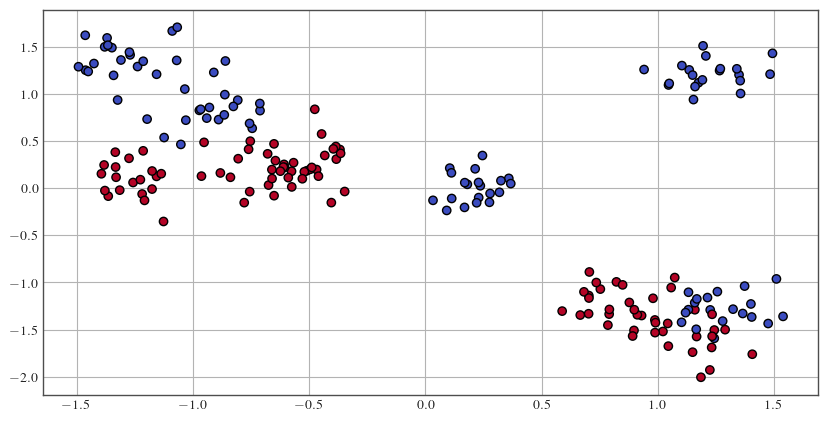

In [39]:
X, y = datasets.make_moons(100, noise=.1, random_state=42)
# X, y = datasets.make_circles(500, noise=.02)
X, y = datasets.make_blobs([20 for _ in range(10)], random_state=12)
y %= 2
X = (X - X.mean(0)) / X.std(0)
X = torch.from_numpy(X).float()
y = torch.from_numpy(y).long()

train_ds = torch.utils.data.TensorDataset(X, y)

plt.scatter(X[:, 0], X[:, 1], c=y)
plt.show()

In [40]:
import lightning as L
import random
import numpy as np

from torch.utils.data.sampler import SubsetRandomSampler

class ALDataModule(L.LightningDataModule):
    def __init__(self, train_dataset, query_dataset=None, train_batch_size=32, seed=None):
        super().__init__()
        self.train_dataset = train_dataset
        self.train_batch_size = train_batch_size

        if query_dataset is None:
            print('Using train_dataset for queries. Make sure that there are no augmentations used.')
            query_dataset = train_dataset
        self.query_dataset = query_dataset

        # Set up the indices for unlabeled and labeled pool
        self.unlabeled_indices = range(len(self.train_dataset))
        self.labeled_indices = []

        # set rng which should be used for all random stuff
        self._seed = seed
        if seed is None:
            self.rng = np.random.mtrand._rand
        else:
            self.rng = np.random.RandomState(self._seed)

    def train_dataloader(self):
        sampler = SubsetRandomSampler(indices=self.labeled_indices)
        train_loader = torch.utils.data.DataLoader(train_ds, batch_size=self.train_batch_size, sampler=sampler)
        return train_loader
    
    def val_dataloader(self):
        return 

    def test_dataloader(self):
        return 

    def update_annotations(self, buy_idx: list):
        """
            Updates the labeled pool with newly annotated samples.

            Args:
                buy_idx (list): List of indices which identify samples of the unlabeled pool that should be
                                transfered to the labeld pool.
        """
        self.labeled_indices = list_union(self.labeled_indices, buy_idx)
        self.unlabeled_indices = list_diff(self.unlabeled_indices, buy_idx)

    def random_init(self, n_samples: int, class_balanced: bool = False):
        """Randomly buys samples from the unlabeled pool and adds them to the labeled one.

            Args:
                n_samples (int): Size of the initial labeld pool.    
                class_balanced (bool): Whether to use an class balanced initialization.
        """
        if len(self.labeled_indices) != 0:
            raise ValueError('Pools already initialized.')

        if class_balanced:
            classes = torch.Tensor([self.query_dataset[idx][-1] for idx in self.unlabeled_indices]).long()
            classes_unique = classes.unique()
            n_classes = len(classes_unique)
            n_samples_per_class = n_samples // n_classes
            
            indices = []
            for label in classes_unique:
                unlabeled_indices_lbl = (classes == label).nonzero().squeeze()
                # indices_lbl = self.rng.sample(unlabeled_indices_lbl.tolist(), k=n_samples_per_class)
                indices_lbl = self.rng.choice(unlabeled_indices_lbl.tolist(), size=n_samples_per_class, replace=False)
                indices_lbl = indices_lbl.tolist()
                indices.extend(indices_lbl)
        else:
            # indices = self.rng.sample(self.unlabeled_indices, k=n_samples)
            indices = self.rng.choice(self.unlabeled_indices, size=n_samples, replace=False)
            indices = indices.tolist()

        self.update_annotations(indices)


def list_union(a: list, b: list):
    return list(set(a).union(set(b)))


def list_diff(a: list, b: list):
    return list(set(a).difference(set(b)))

al_module = ALDataModule(train_dataset=train_ds)
al_module.random_init(2, class_balanced=True)
train_loader = al_module.train_dataloader()
next(iter(train_loader))

Using train_dataset for queries. Make sure that there are no augmentations used.


[tensor([[-1.3638, -0.0829],
         [ 1.1596,  1.0809]]),
 tensor([1, 0])]

In [41]:
from dal_toolbox.models.deterministic.base import DeterministicModule

class Net(DeterministicModule):
    def __init__(self, num_classes: int, dropout_rate: int = .2, feature_dim: int = 128,):
        super().__init__()

        self.first = nn.Linear(2, feature_dim)
        self.first_dropout = nn.Dropout(dropout_rate)
        self.hidden = nn.Linear(feature_dim, feature_dim)
        self.hidden_dropout = nn.Dropout(dropout_rate)
        self.last = nn.Linear(feature_dim, num_classes)
        self.act = nn.ReLU()

    def forward(self, x, return_features=False):
        x = self.act(self.first(x))
        x = self.first_dropout(x)
        x = self.act(self.hidden(x))
        x = self.hidden_dropout(x)
        out = self.last(x)
        if return_features:
            return out, x
        return out

    def configure_optimizers(self):
        return torch.optim.SGD(self.parameters(), lr=1e-1, momentum=.9, weight_decay=0.01)

    @torch.inference_mode()
    def get_probas(self, dataloader, device):
        self.to(device)
        self.eval()
        all_logits = []
        for samples, _ in dataloader:
            logits = self(samples.to(device))
            all_logits.append(logits)
        logits = torch.cat(all_logits)
        probas = logits.softmax(-1)
        return probas

    @torch.inference_mode()
    def get_grad_embedding(self, dataloader, n_samples, device):
        self.eval()
        self.to(device)
        feature_dim = 128
        self.num_classes = 2

        embedding = torch.zeros([n_samples, feature_dim * self.num_classes])
        for inputs, _ in dataloader:
            logits, features = self(inputs.to(device), return_features=True)
            logits = logits.cpu()
            features = features.cpu()

            probas = logits.softmax(-1)
            max_indices = probas.argmax(-1)

            # TODO: optimize code
            # for each sample in a batch and for each class
            for n in range(len(inputs)):
                for c in range(self.num_classes):
                    if c == max_indices[n]:
                        embedding[n, feature_dim * c: feature_dim * (c+1)] = features[n] * (1 - probas[n, c])
                    else:
                        embedding[n, feature_dim * c: feature_dim * (c+1)] = features[n] * (-1 * probas[n, c])
        return torch.Tensor(embedding)

In [42]:
def dataset_to_xy(dataset):
    X, y = [], []
    for inp, tar in dataset:
        X.append(inp)
        y.append(tar)
    X = torch.stack(X).float()
    y = torch.Tensor(y).long()
    return X, y

@torch.no_grad()
def plot_contour(model, dataset, unlabeled_indices, labeled_indices, ax=None):
    X, y = dataset_to_xy(dataset)

    model.eval()
    model.cpu()
    if ax:
        plt.sca(ax)
    domain = 5
    xx, yy = torch.meshgrid(torch.linspace(-domain, domain, 51), torch.linspace(-domain, domain, 51))
    zz = torch.stack((xx.flatten(), yy.flatten()), dim=1)

    logits = model(zz)
    probas = logits.softmax(-1)
    zz = probas[:, 1].view(xx.shape)

    # plt.title(f"Ep {}")
    plt.scatter(X[unlabeled_indices, 0], X[unlabeled_indices, 1], s=1)
    plt.scatter(X[labeled_indices, 0], X[labeled_indices, 1], c=y[labeled_indices], s=100)
    plt.contourf(xx, yy, zz, alpha=.8, zorder=-1, levels=np.linspace(0, 1, 6))
    plt.colorbar()

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/denis/miniconda3/envs/dal-toolbox/lib/python3.9/site-packages/lightning/pytorch/trainer/configuration_validator.py:70: UserWarning: You passed in a `val_dataloader` but have no `validation_step`. Skipping val loop.
  rank_zero_warn("You passed in a `val_dataloader` but have no `validation_step`. Skipping val loop.")
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type    | Params
-------------------------------------------
0 | first          | Linear  | 384   
1 | first_dropout  | Dropout | 0     
2 | hidden         | Linear  | 16.5 K
3 | hidden_dropout | Dropout | 0     
4 | last           | Linear  | 258   
5 | act            | ReLU    | 0     
-------------------------------------------
17.2 K    Trainable params
0         Non-trainable params
17.2 K    Total params
0.069     Total estimated model params size (M

Using train_dataset for queries. Make sure that there are no augmentations used.


/home/denis/miniconda3/envs/dal-toolbox/lib/python3.9/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:430: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/home/denis/miniconda3/envs/dal-toolbox/lib/python3.9/site-packages/lightning/pytorch/loops/fit_loop.py:280: PossibleUserWarning: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  rank_zero_warn(
`Trainer.fit` stopped: `max_epochs=100` reached.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


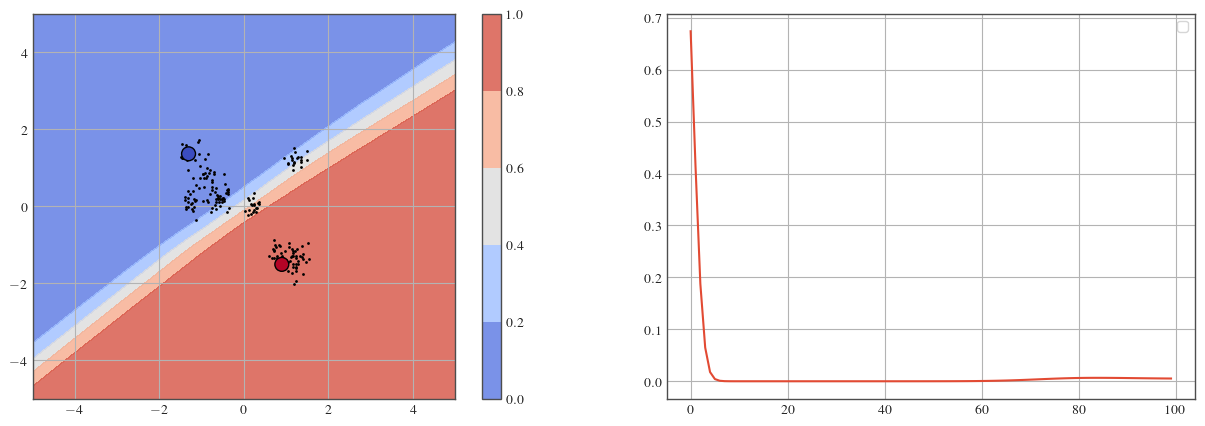

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type    | Params
-------------------------------------------
0 | first          | Linear  | 384   
1 | first_dropout  | Dropout | 0     
2 | hidden         | Linear  | 16.5 K
3 | hidden_dropout | Dropout | 0     
4 | last           | Linear  | 258   
5 | act            | ReLU    | 0     
-------------------------------------------
17.2 K    Trainable params
0         Non-trainable params
17.2 K    Total params
0.069     Total estimated model params size (MB)
`Trainer.fit` stopped: `max_epochs=100` reached.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


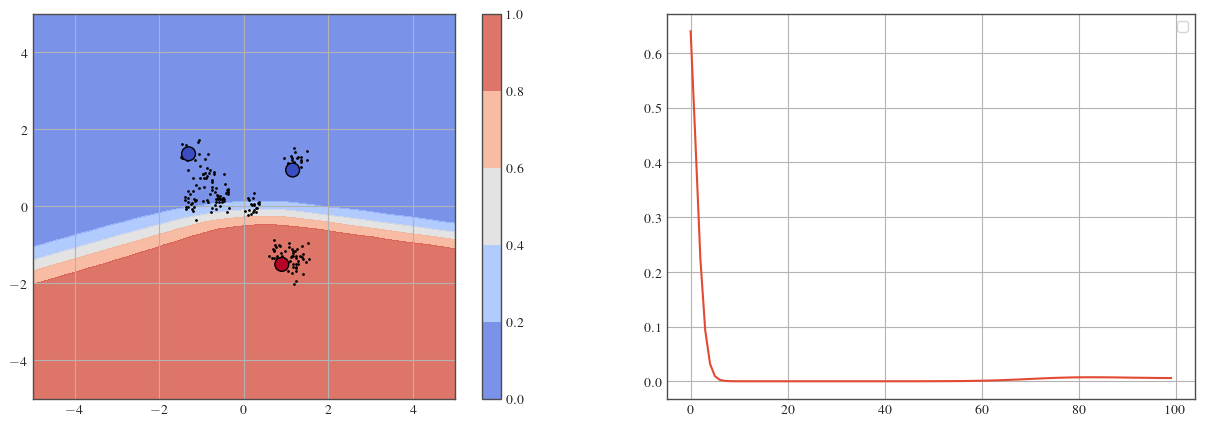

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type    | Params
-------------------------------------------
0 | first          | Linear  | 384   
1 | first_dropout  | Dropout | 0     
2 | hidden         | Linear  | 16.5 K
3 | hidden_dropout | Dropout | 0     
4 | last           | Linear  | 258   
5 | act            | ReLU    | 0     
-------------------------------------------
17.2 K    Trainable params
0         Non-trainable params
17.2 K    Total params
0.069     Total estimated model params size (MB)
`Trainer.fit` stopped: `max_epochs=100` reached.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


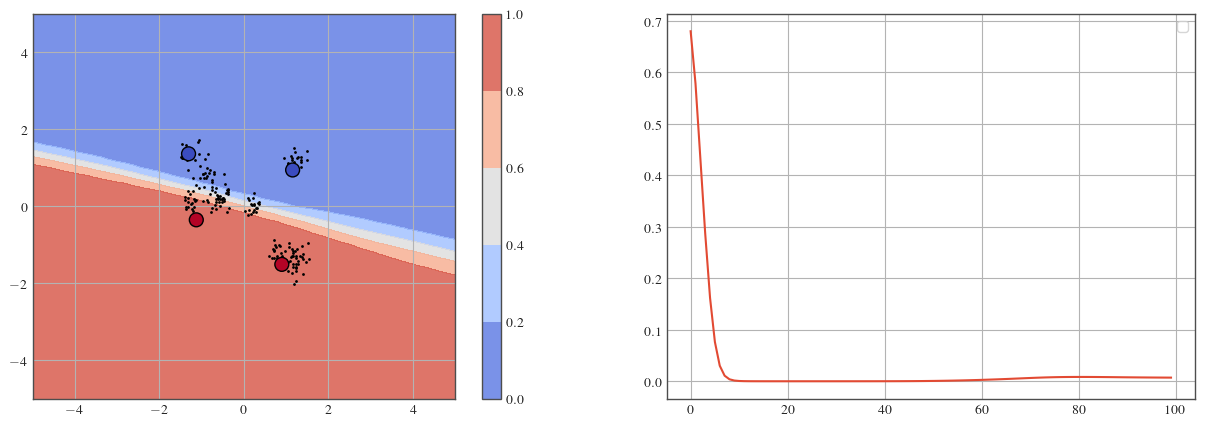

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type    | Params
-------------------------------------------
0 | first          | Linear  | 384   
1 | first_dropout  | Dropout | 0     
2 | hidden         | Linear  | 16.5 K
3 | hidden_dropout | Dropout | 0     
4 | last           | Linear  | 258   
5 | act            | ReLU    | 0     
-------------------------------------------
17.2 K    Trainable params
0         Non-trainable params
17.2 K    Total params
0.069     Total estimated model params size (MB)
`Trainer.fit` stopped: `max_epochs=100` reached.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


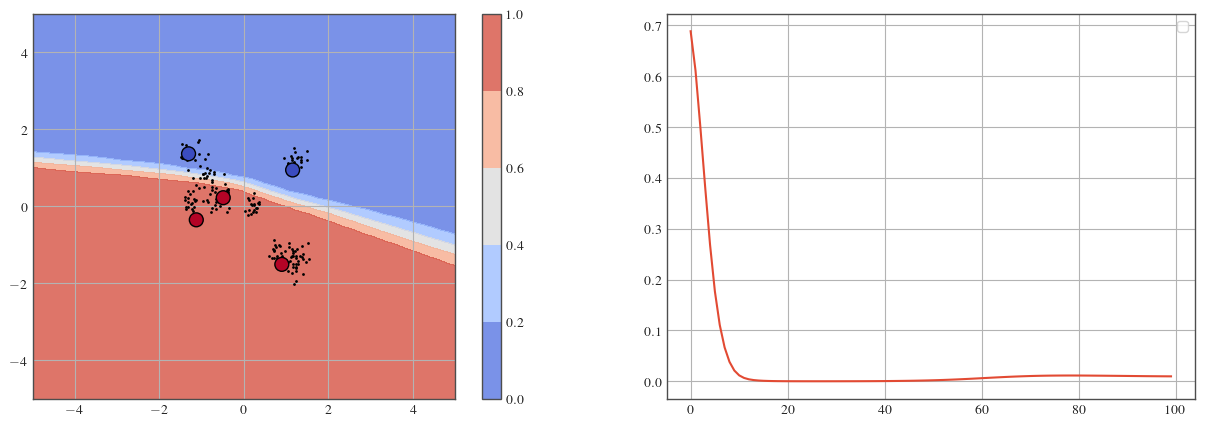

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type    | Params
-------------------------------------------
0 | first          | Linear  | 384   
1 | first_dropout  | Dropout | 0     
2 | hidden         | Linear  | 16.5 K
3 | hidden_dropout | Dropout | 0     
4 | last           | Linear  | 258   
5 | act            | ReLU    | 0     
-------------------------------------------
17.2 K    Trainable params
0         Non-trainable params
17.2 K    Total params
0.069     Total estimated model params size (MB)
`Trainer.fit` stopped: `max_epochs=100` reached.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


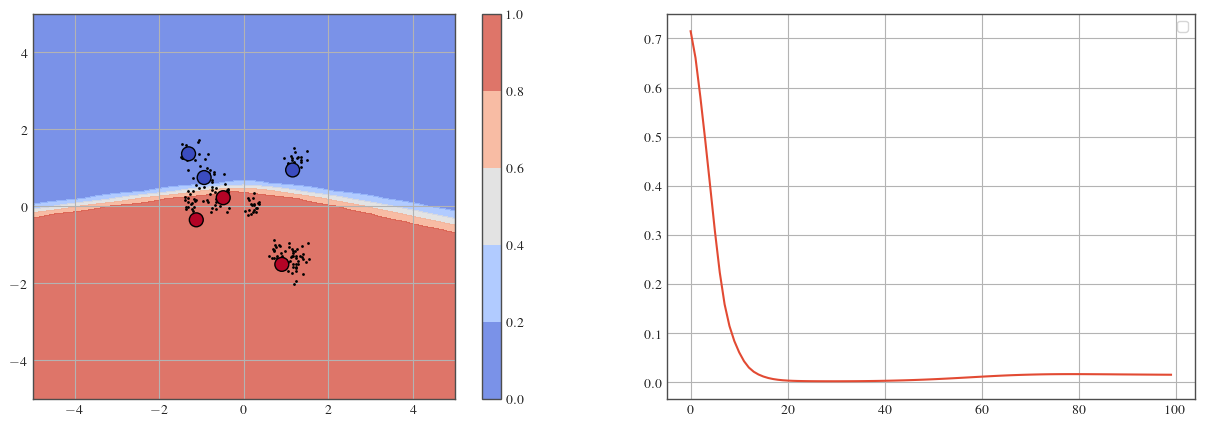

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type    | Params
-------------------------------------------
0 | first          | Linear  | 384   
1 | first_dropout  | Dropout | 0     
2 | hidden         | Linear  | 16.5 K
3 | hidden_dropout | Dropout | 0     
4 | last           | Linear  | 258   
5 | act            | ReLU    | 0     
-------------------------------------------
17.2 K    Trainable params
0         Non-trainable params
17.2 K    Total params
0.069     Total estimated model params size (MB)
`Trainer.fit` stopped: `max_epochs=100` reached.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


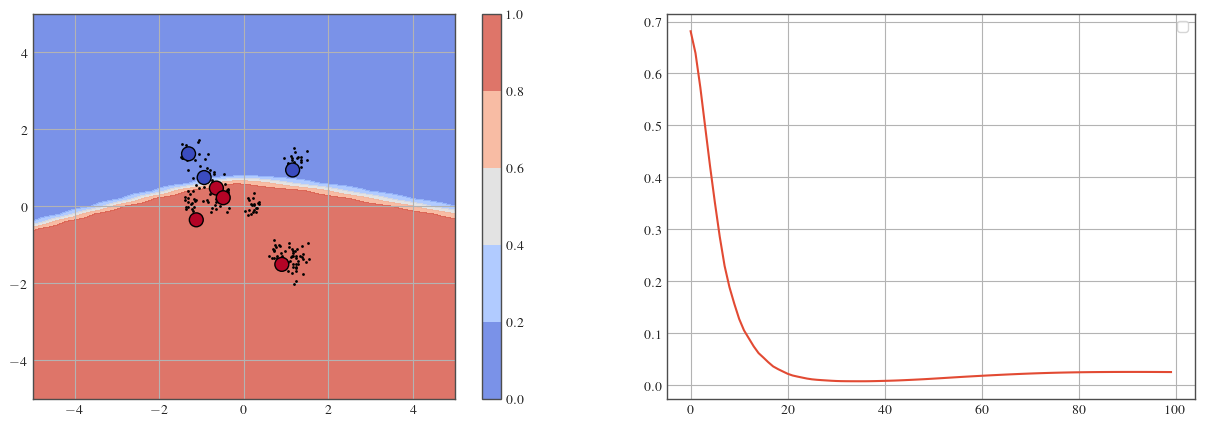

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type    | Params
-------------------------------------------
0 | first          | Linear  | 384   
1 | first_dropout  | Dropout | 0     
2 | hidden         | Linear  | 16.5 K
3 | hidden_dropout | Dropout | 0     
4 | last           | Linear  | 258   
5 | act            | ReLU    | 0     
-------------------------------------------
17.2 K    Trainable params
0         Non-trainable params
17.2 K    Total params
0.069     Total estimated model params size (MB)
`Trainer.fit` stopped: `max_epochs=100` reached.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


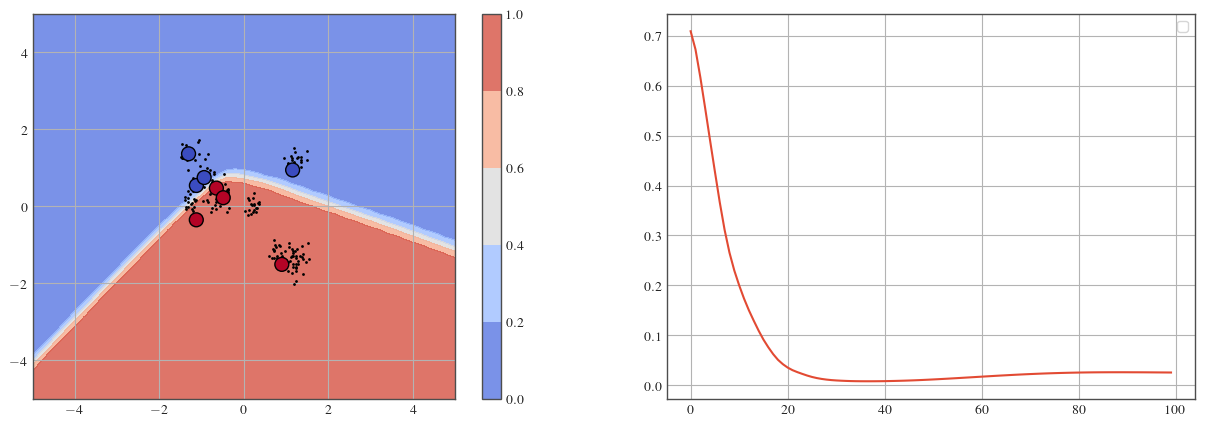

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type    | Params
-------------------------------------------
0 | first          | Linear  | 384   
1 | first_dropout  | Dropout | 0     
2 | hidden         | Linear  | 16.5 K
3 | hidden_dropout | Dropout | 0     
4 | last           | Linear  | 258   
5 | act            | ReLU    | 0     
-------------------------------------------
17.2 K    Trainable params
0         Non-trainable params
17.2 K    Total params
0.069     Total estimated model params size (MB)
`Trainer.fit` stopped: `max_epochs=100` reached.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


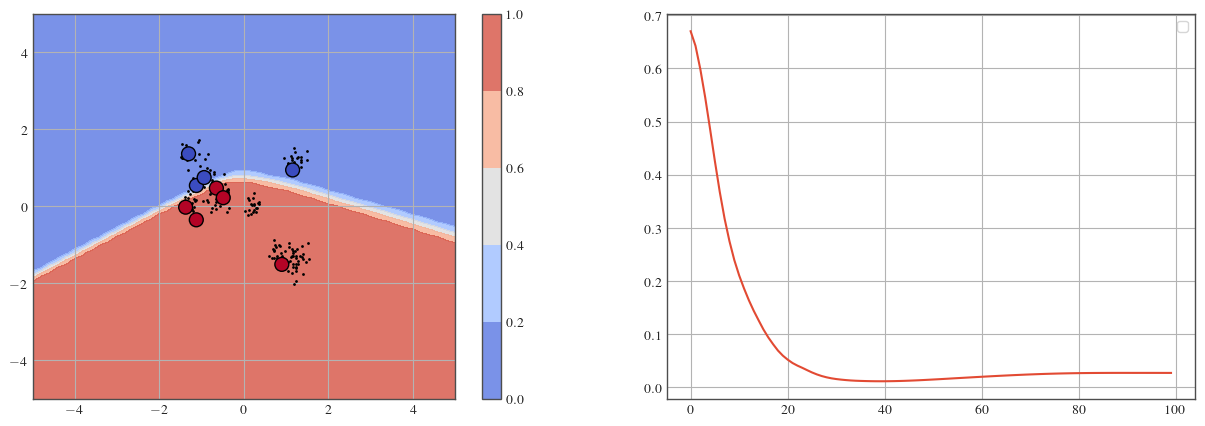

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type    | Params
-------------------------------------------
0 | first          | Linear  | 384   
1 | first_dropout  | Dropout | 0     
2 | hidden         | Linear  | 16.5 K
3 | hidden_dropout | Dropout | 0     
4 | last           | Linear  | 258   
5 | act            | ReLU    | 0     
-------------------------------------------
17.2 K    Trainable params
0         Non-trainable params
17.2 K    Total params
0.069     Total estimated model params size (MB)
`Trainer.fit` stopped: `max_epochs=100` reached.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


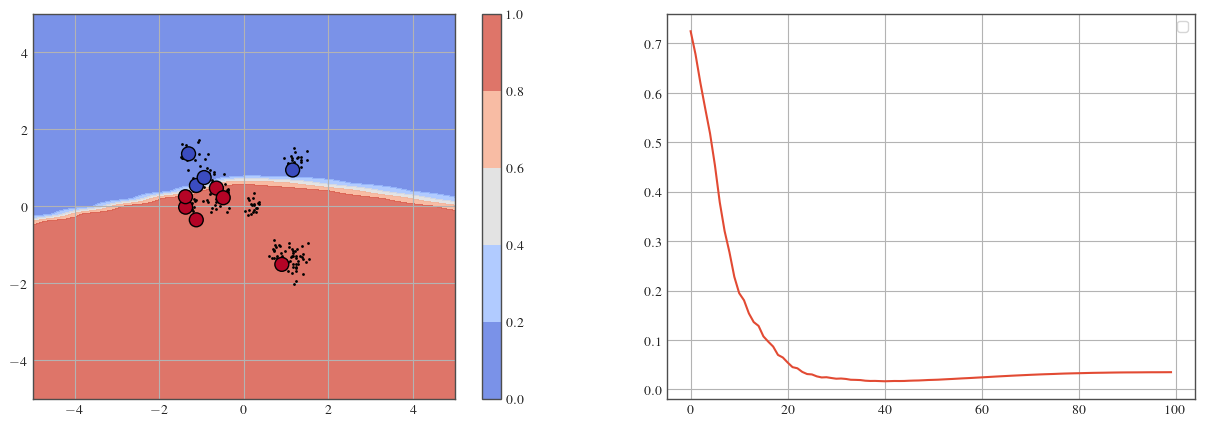

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type    | Params
-------------------------------------------
0 | first          | Linear  | 384   
1 | first_dropout  | Dropout | 0     
2 | hidden         | Linear  | 16.5 K
3 | hidden_dropout | Dropout | 0     
4 | last           | Linear  | 258   
5 | act            | ReLU    | 0     
-------------------------------------------
17.2 K    Trainable params
0         Non-trainable params
17.2 K    Total params
0.069     Total estimated model params size (MB)
`Trainer.fit` stopped: `max_epochs=100` reached.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


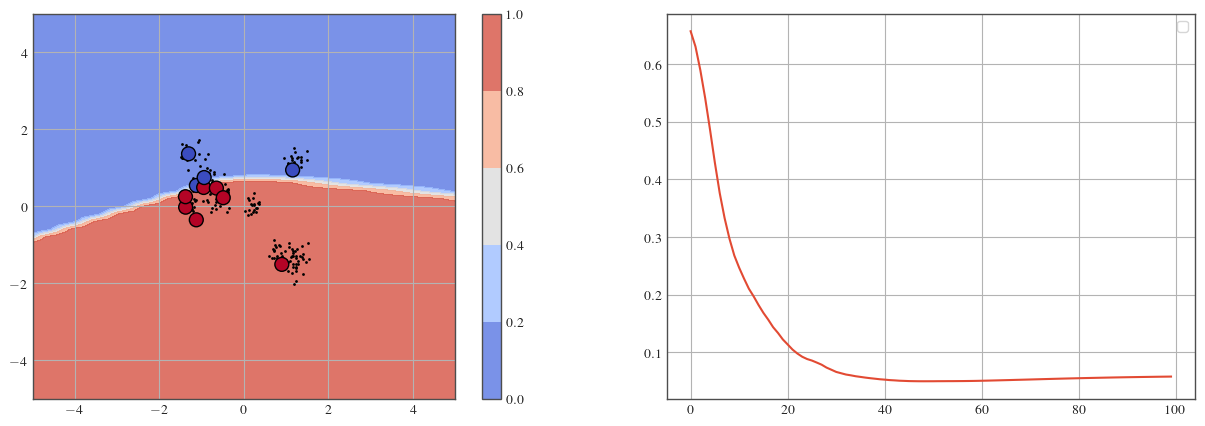

In [43]:
from dal_toolbox.models.utils.callbacks import MetricsHistory
from dal_toolbox.active_learning.strategies import uncertainty

# Train args
np.random.seed(0)
torch.manual_seed(0)
dropout_rate = 0.0
epochs = 100
n_cycles = 10

# AL Setup
al_datamodule = ALDataModule(train_ds)
al_datamodule.random_init(2, class_balanced=True)
uncertainty_sampling = uncertainty.EntropySampling()

    
for i_cycle in range(n_cycles):
    if i_cycle != 0:
        indices = uncertainty_sampling.query(
            model,
            al_datamodule.query_dataset,
            al_datamodule.unlabeled_indices,
            acq_size=1
        )
        al_datamodule.update_annotations(indices)
    
    history = MetricsHistory()
    model = Net(dropout_rate=dropout_rate, num_classes=2)
    trainer = L.Trainer(max_epochs=epochs, callbacks=[history], enable_progress_bar=False)
    trainer.fit(model, al_datamodule)

    plt.figure(figsize=(15, 5))
    plt.subplot(122)
    plt.plot([d[f'loss'] for d in history])
    plt.legend()
    plot_contour(model, al_datamodule.query_dataset, al_datamodule.unlabeled_indices, al_datamodule.labeled_indices, ax=plt.subplot(121))
    plt.show()